<a href="https://colab.research.google.com/github/danghaophu/phu/blob/main/modelunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5e5bdd6f4c4a369030bd88b08460e30091a553c0f2a374a0415ad82f9f4d35e1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=00e97b8d9879e767f790a915442a126e87408d2b520fd5b

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.2 MB/s eta 0:00:00


In [2]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz.tar.gz


--2023-10-10 15:51:40--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-10-10 15:51:40--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  26.2MB/s    in 31s     

2023-10-10 15:52:11 (24.6 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-10-10 15:52:11--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots

In [3]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2023-10-10 15:53:35--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz [following]
--2023-10-10 15:53:36--  https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  10.3MB/s    in 1.8s    

2023-10-10 15:53:38 (10.3 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset,dataloader
import torchmetrics
from torchmetrics import Dice,JaccardIndex
import segmentation_models_pytorch as samp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
from glob import glob


[1 2 3]


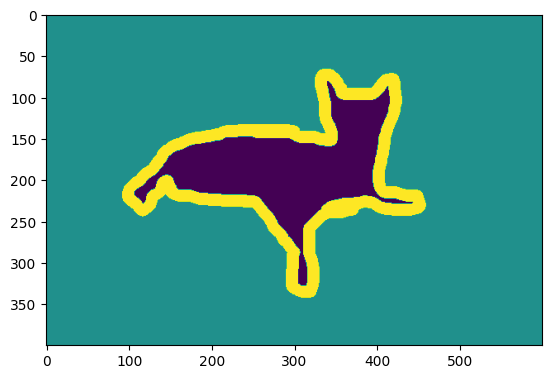

In [ ]:
mask_path='/content/annotations/trimaps/Abyssinian_1.png'
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)
print(np.unique(mask))

In [ ]:
image_path=''

In [ ]:
def unet_block(in_channels,out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3,1,1),
      nn.ReLU(),
      nn.Conv2d(out_channels,out_channels,3,1,1),
      nn.ReLU()
  )

class Unet(nn.Module):
  def __init__(self,n_classes):
    super().__init__()
    self.n_classes=n_classes
    self.downsample=nn.MaxPool2d(2)
    self.upsample=nn.Upsample(scale_factor=2,mode='bilinear')
    self.block_down1=unet_block(3,64)
    self.block_down2=unet_block(64,128)
    self.block_down3=unet_block(64,256)
    self.block_down4=unet_block(256,512)
    self.block_neek=unet_block(512,1024)
    self.block_up1=unet_block(1024+512,512)
    self.block_up2=unet_block(512+256,256)
    self.block_up3=unet_block(128+256,128)
    self.block_up4=unet_block(128+64,64)
    self.conv_cls=nn.Conv2d(64,self.n_classes,1)
  def forward(self,x):
    x1=self.block_down1(x)
    x=self.downsample(x1)
    x2=self.block_down2(x)
    x=self.downsample(x2)
    x3=self.block_down3(x)
    x=self.downsample(x3)
    x4=self.block_down4(x)
    x=self.downsample(x4)
    x=self.block_neek(x)

    x=torchmetrics.cat([x4,self.upsample(x)],dim=1)
    x=self.block_up1(x)
    x=torchmetrics.cat([x3,self.upsample(x)],dim=1)
    x=self.block_up2(x)
    x=torchmetrics.cat([x2,self.upsample(x)],dim=1)
    x=self.block_up3(x)
    x=torchmetrics.cat([x1,self.upsample(x)],dim=1)
    x=self.block_up4(x)

    x=self.conv_cls(x)
    return(x)
model=Unet(1)

In [7]:
!unzip /content/age_gender_estimation-master.zip



Archive:  /content/age_gender_estimation-master.zip
459207a48928635546bd0601da62a60b2bde6e83
   creating: age_gender_estimation-master/
  inflating: age_gender_estimation-master/README.md  
  inflating: age_gender_estimation-master/age_gender_estimation.ipynb  
  inflating: age_gender_estimation-master/config.py  
   creating: age_gender_estimation-master/data/
  inflating: age_gender_estimation-master/data/create_db.py  
  inflating: age_gender_estimation-master/data/utils.py  
  inflating: age_gender_estimation-master/data_provider.py  
  inflating: age_gender_estimation-master/data_utils.py  
  inflating: age_gender_estimation-master/inference_img.py  
  inflating: age_gender_estimation-master/model.py  
  inflating: age_gender_estimation-master/selenagomez.jpg  
